In [166]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nussl
from utils import viz, data
import yaml
import os

In [192]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

In [124]:
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
nussl.ml.register_module(MaskInference)
nussl.ml.register_module(UNetSpect)

In [125]:
os.listdir('models/')

['ST_unet_16f_nonlog',
 '.ipynb_checkpoints',
 'ST_mask_10_256_32hop',
 'ST_mask_5layer_1e-2LR',
 'ST_mask_10_256_0.3dropout',
 'test_auto',
 '__pycache__',
 'ST_unet_32f_nonlog',
 'ST_mask_5layer_256hidden',
 'MaskInference.py',
 'ST_mask_10_256_1e-4LR',
 'Waveform.py',
 'ST_unet_16f_logscale',
 'UNet.py',
 'Filterbank.py',
 'ST_mask_1layer',
 'ST_mask_5layer',
 'ST_mask_10layer',
 'ST_unet_8f_nonlog',
 'Clustering.py',
 'ST_mask_10layer_256hidden']

In [126]:
model_name = 'ST_mask_10layer'

In [127]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
config_path = 'models/'+model_name+'/configs.yml'
#Optimizer checkpoints no longer stored
#optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'

In [128]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()
stft_params = nussl.STFTParams(**configs['stft_params'])

In [129]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
#Optimizer checkpoints no longer stored
#optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [131]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 25,
 'epoch_length': 25,
 'max_epochs': 25,
 'output': {'loss_L1': 0.00039298716001212597, 'loss': 0.00039298716001212597},
 'metrics': {'avg_loss': 0.0005412800278788415},
 'seed': None}

In [132]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

Text(0.5, 0, 'Epoch')

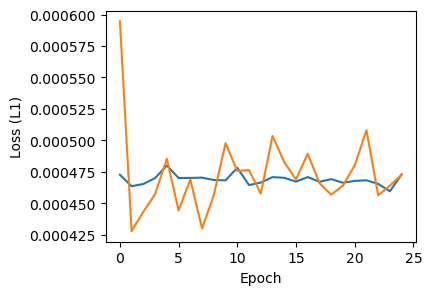

In [133]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss)
plt.plot(x,train_loss)
plt.ylabel('Loss (L1)')
plt.xlabel('Epoch')

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


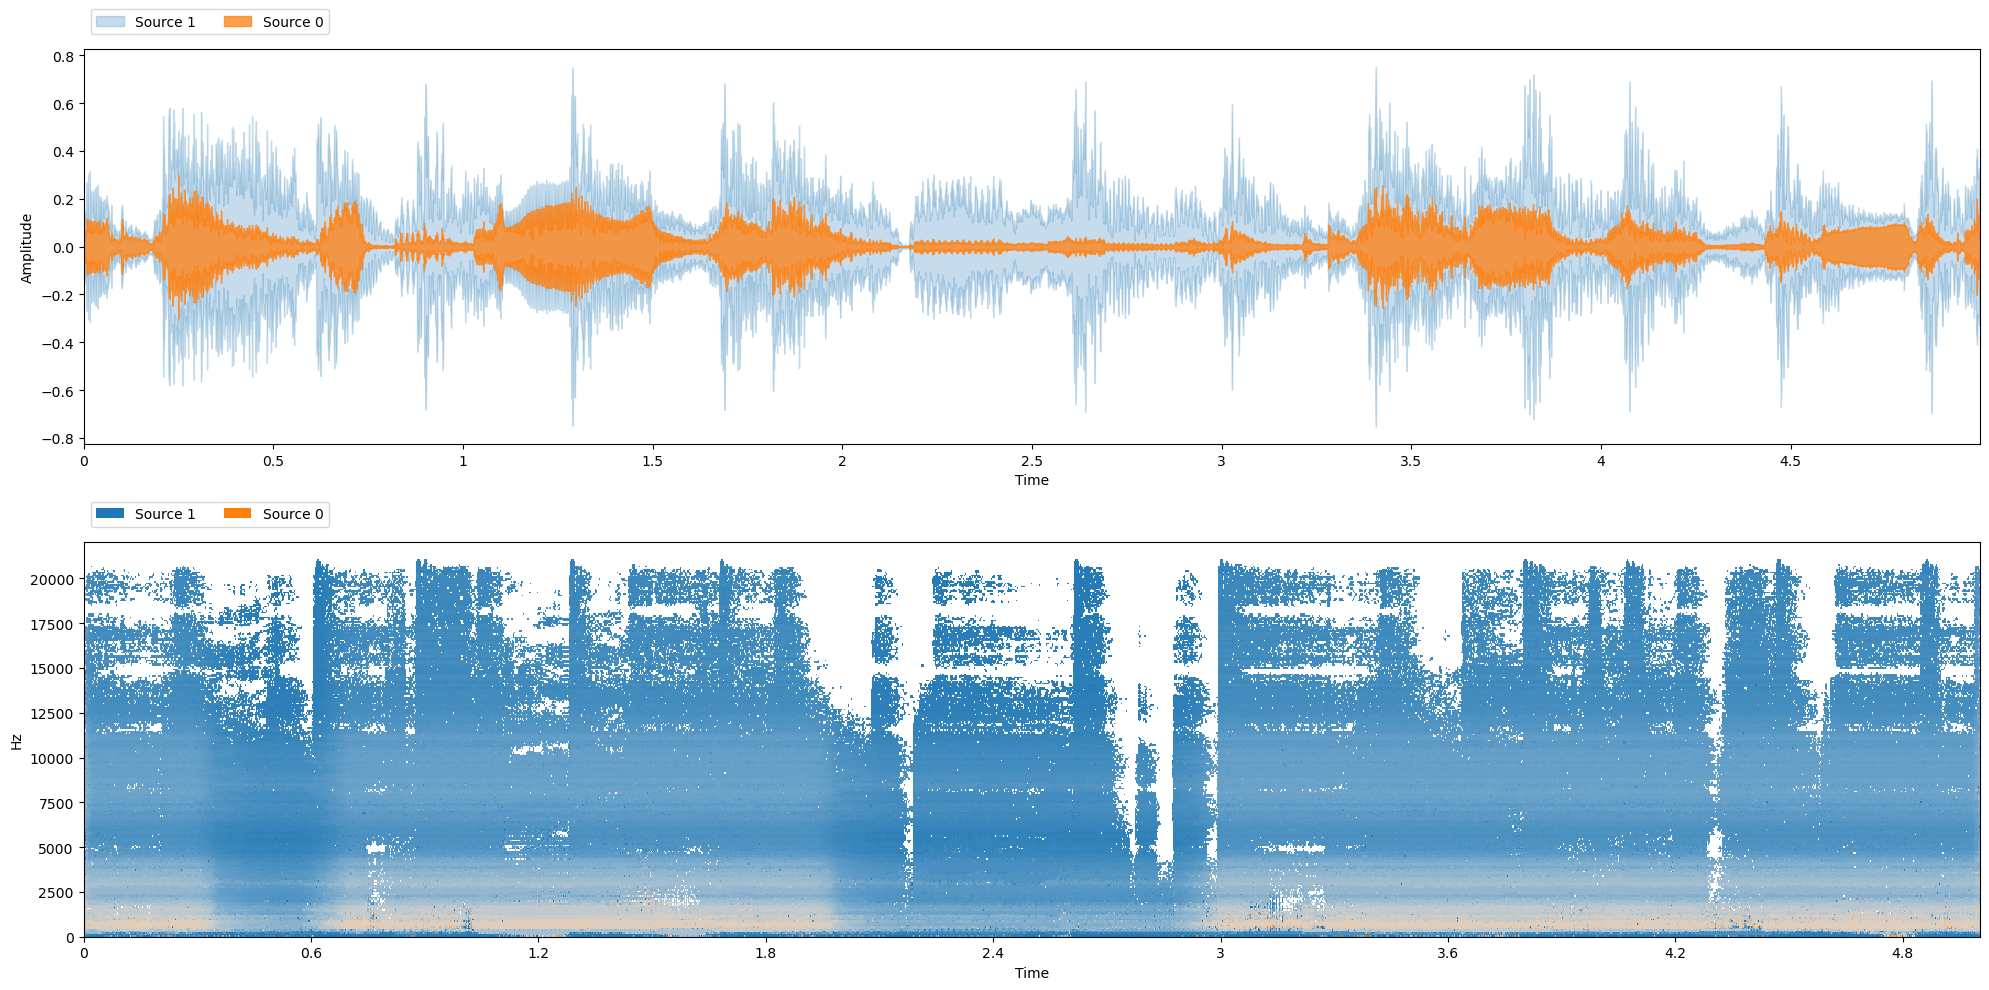


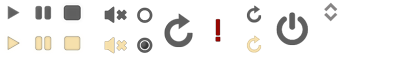
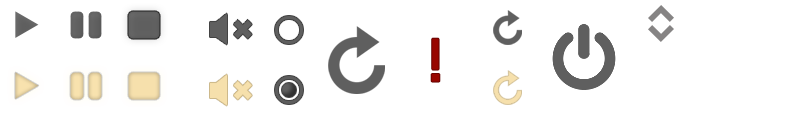
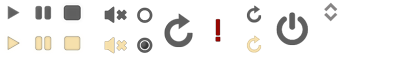

In [201]:
#Load in the model
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path=model_path,
    device='cpu',
)

#Test on the data
test_folder = configs['test_folder']
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
test_data = data.mixer(stft_params, transform=tfm, fg_path=configs['test_folder'], num_mixtures=999999, coherent_prob=1.0, duration=5)

item = test_data[1]
separator.audio_signal = item['mix']
estimates = separator()
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)

In [202]:
# Just do 5 items for speed. Change to 50 for actual experiment.
source_keys = list(test_data[0]['sources'].keys())
all_scores = {}
for source in source_keys:
    all_scores[source] = {}

for i in range(5):
    item = test_data[i]
    separator.audio_signal = item['mix']
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'bass+drums+other': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()
    for source in source_keys:
        for score in scores[source]:
            if score not in all_scores[source].keys():
                all_scores[source][score] = scores[source][score]
            else:
                all_scores[source][score] += scores[source][score]
    

In [205]:
data_log = []
for source in source_keys:
    row = {'Source':source, 'Model':configs['model_type']}
    if 'stft_params' in configs.keys():
        for stft_param in configs['stft_params'].keys():
            row['STFT '+stft_param] = configs['stft_params'][stft_param]
    for model_param in configs['model_params'].keys():
        row['Model '+model_param] = configs['model_params'][model_param]
    for optimizer_param in configs['optimizer_params'].keys():
        row['Optimizer '+optimizer_param] = configs['optimizer_params'][optimizer_param]
    row.update({'Epochs':configs['train_params']['max_epochs'],
                'Epoch Length':configs['train_params']['epoch_length'],
                'Train Coherent Fraction':configs['train_generator_params']['coherent_prob'],
                'Batch Size': configs['batch_size']
               })
    for score in all_scores[source]:
        row[score] = np.array(all_scores[source][score]).mean()
    data_log.append(row)

data_log = pd.DataFrame(data_log)

In [206]:
data_log

,Source,Model,STFT window_length,STFT hop_length,STFT window_type,Model num_audio_channels,Model hidden_size,Model num_layers,Model bidirectional,Model dropout,...,SI-SAR,SD-SDR,SNR,SRR,SI-SDRi,SD-SDRi,SNRi,MIX-SI-SDR,MIX-SD-SDR,MIX-SNR
0,vocals,Mask,512,128,sqrt_hann,1,64,10,True,0.1,...,-2.698464,-13.482561,1.630911,-12.519436,2.647303,-6.491589,8.556043,-6.989997,-6.990972,-6.925132
1,bass+drums+other,Mask,512,128,sqrt_hann,1,64,10,True,0.1,...,18.532656,7.748559,8.556043,21.165099,1.157937,0.866434,1.630911,6.883100,6.882125,6.925132
